✅ Found 3264 images across 4 classes
🧾 Class distribution:
 class
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
📊 Train: 2219, Val: 392, Test: 653
Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 121s 782ms/step - accuracy: 0.3451 - loss: 1.9310 - val_accuracy: 0.2755 - val_loss: 1.5044
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 403ms/step - accuracy: 0.4707 - loss: 1.6684 - val_accuracy: 0.1250 - val_loss: 1.8390
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.5337 - loss: 1.3568 - val_accuracy: 0.3010 - val_loss: 1.9449
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.5592 - loss: 1.2983 - val_accuracy: 0.3214 - val_loss: 3.3599
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.6308 - loss: 1.1467 - val_accuracy: 0.3597 - val_loss: 2.4593
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.6667 - loss: 0.9811 - val_accuracy: 0.5536 - val_loss: 1.2668
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 404ms/step - accuracy: 0.6791 - loss: 0.9786 - val_accuracy: 0.4464 - val_loss: 1.8186
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - accuracy: 0.6941 - loss: 0.8142 - val_acc

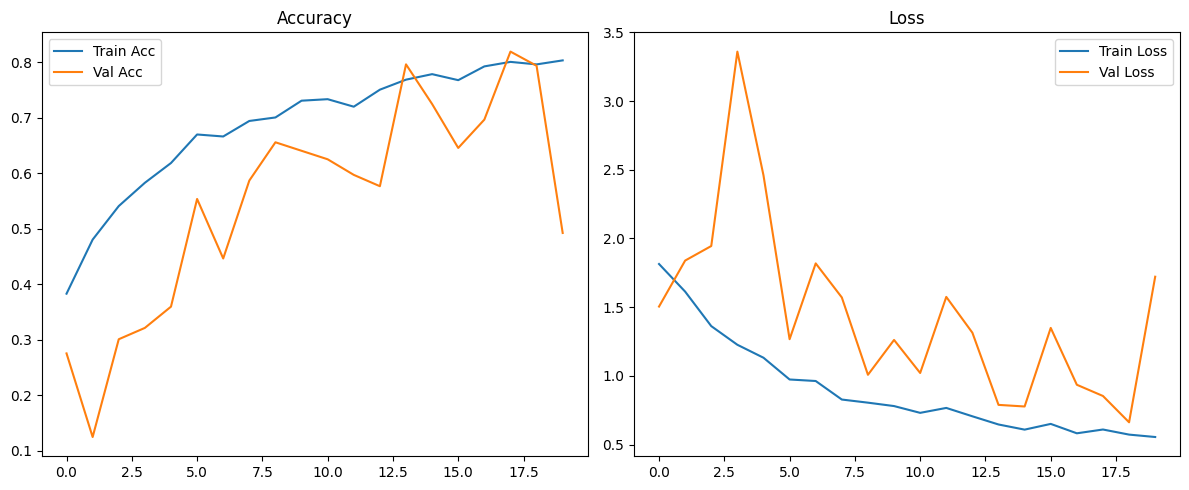

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7522 - loss: 0.7788
✅ Test Accuracy: 0.7642
📉 Test Loss: 0.7450
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.74      0.83      0.78       185
meningioma_tumor       0.76      0.54      0.63       188
        no_tumor       0.62      0.96      0.75       100
 pituitary_tumor       0.95      0.82      0.88       180

        accuracy                           0.76       653
       macro avg       0.77      0.79      0.76       653
    weighted avg       0.78      0.76      0.76       653



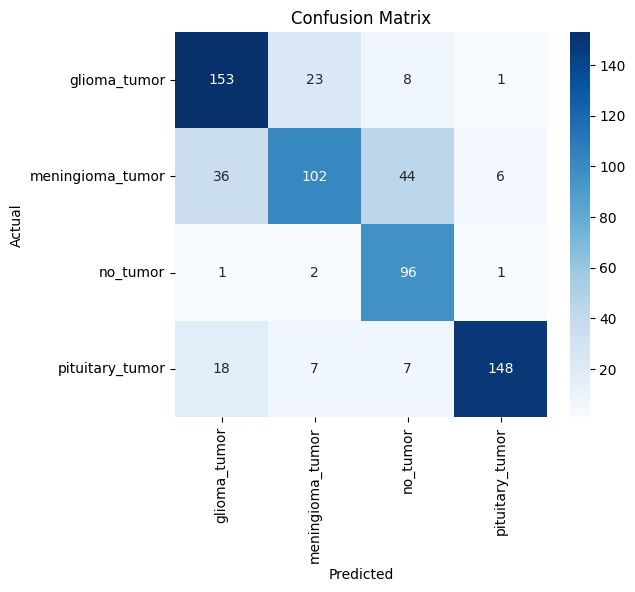

In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ======================
# ⚙️ Parameters
# ======================
train_dir = "/kaggle/input/sartaj-dataset/Training"
test_dir  = "/kaggle/input/sartaj-dataset/Testing"

IMG_SIZE = (224, 224)  # ResNet50 also expects 224x224
BATCH_SIZE = 32
EPOCHS = 20   # you can increase for better accuracy

# ======================
# 🗂 Step 1: Load dataset paths
# ======================
image_paths = glob.glob(os.path.join(train_dir, "**", "*.*"), recursive=True)
image_paths += glob.glob(os.path.join(test_dir, "**", "*.*"), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_paths) == 0:
    raise ValueError("❌ No images found. Please check dataset path.")

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'class': labels})

NUM_CLASSES = df['class'].nunique()
print(f"✅ Found {len(df)} images across {NUM_CLASSES} classes")
print("🧾 Class distribution:\n", df['class'].value_counts())

# ======================
# 🧪 Step 2: Split dataset
# ======================
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ======================
# 🔄 Step 3: Data generators
# ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# ======================
# 🔧 Step 4: Build ResNet50 model (from scratch)
# ======================
base_model = ResNet50(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ======================
# ⚙️ Step 5: Compile
# ======================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ======================
# 📦 Step 6: Callbacks
# ======================
checkpoint = ModelCheckpoint('resnet50_scratch_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ======================
# 🏋️ Step 7: Train
# ======================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# ======================
# 📈 Step 8: Plot history
# ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 🧪 Step 9: Evaluate on test set
# ======================
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# ======================
# 🧾 Step 10: Classification report & confusion matrix
# ======================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
